# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. Take Actions from DDPG agent in the Environment

Once this cell is executed, you will watch the agent's performance, with DDPG. A window should pop up that allows you to observe the agent, as it moves through the environment.
This will train the agent until he reaches a 0.5 score!

In [5]:
def run_ddpg_for_one_episode(agent, env, brain_name, is_training):
    """Run the DDPG agent for one episode"""
    env_info = env.reset(train_mode=is_training)[brain_name]   # reset the environment    
    states = env_info.vector_observations                       # get the current state (for the agent)
    states = states.ravel()
    scores = np.zeros(num_agents)                                                 # initialize the score (for the agent)
    step_num = 0
    rebound_memory = []                                        # save all the agent variables to the last rebound of an episode
    short_term_memory = []                                     # save all the agent variables between the last two important steps 
                                                               #(reward of 0.1 or -0.01) 
    number_of_rebounds = 0                               # get how many times the ball has rebound
    no_bounce = True
    while True:
        flat_actions = agent.act(states, add_noise=is_training)            # select an action (for both agents)
        actions = flat_actions.reshape((2, -1)) 
        env_info = env.step(actions)[brain_name]             # send all actions to tne environment
        next_states = env_info.vector_observations           # get next state (for each agent)
        next_states = next_states.ravel()                    # flatten the states
        rewards = env_info.rewards                           # get reward (for each agent)
        dones = env_info.local_done                          # see if episode finished
        if is_training:
            done = np.any(dones)
            short_term_memory.append([states, flat_actions, 0, next_states, done])
            if np.isclose(np.max(rewards), 0.1):
                number_of_rebounds += 1
                rebound_memory += short_term_memory
                short_term_memory = []
            elif np.isclose(np.min(rewards), -0.01):
                if number_of_rebounds:
                    rebound_memory_array = np.array(rebound_memory)
                    num_elements = len(rebound_memory)
                    rebound_memory_array[:, 2] += np.linspace(number_of_rebounds + 0.1*num_elements, number_of_rebounds, num_elements) 
                losing_memory_array = np.array(short_term_memory)
                losing_memory_array[:, 2] += np.arange(0, -len(short_term_memory), -1) * 0.01
                if number_of_rebounds:
                    learning_memory_array = np.append(rebound_memory_array, losing_memory_array, axis=0)
                    no_bounce = False
                else:
                    learning_memory_array = losing_memory_array
                agent.step(learning_memory_array, no_bounce)
                short_term_memory = []
        scores += rewards                                        # update the score (for each agent)
        states = next_states                                 # roll over states to next time step
        step_num += 1
        if np.any(dones):                                               # exit loop if episode finished
            return scores

def ddpg(env, brain_name, n_episodes=5000, print_every=100, finish_score=0.5):
    agent = Agent(state_size=2*state_size, action_size=2*action_size, random_seed=0)
    scores_deque = deque(maxlen=print_every)
    scores = []                        # All the scores
    for i_episode in range(1, n_episodes+1):
        score = np.max(run_ddpg_for_one_episode(agent, env, brain_name, True)) 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=finish_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores

C:\Users\medmo\anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Episode 100	Average Score: 0.00
Episode 103	Average Score: 0.00

C:\Users\medmo\anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Episode 200	Average Score: 0.02
Episode 300	Average Score: 0.02
Episode 400	Average Score: 0.06
Episode 500	Average Score: 0.08
Episode 600	Average Score: 0.09
Episode 700	Average Score: 0.09
Episode 800	Average Score: 0.09
Episode 900	Average Score: 0.09
Episode 1000	Average Score: 0.09
Episode 1100	Average Score: 0.13
Episode 1200	Average Score: 0.16
Episode 1300	Average Score: 0.14
Episode 1400	Average Score: 0.14
Episode 1500	Average Score: 0.13
Episode 1600	Average Score: 0.11
Episode 1700	Average Score: 0.21
Episode 1800	Average Score: 0.18
Episode 1900	Average Score: 0.16
Episode 2000	Average Score: 0.17
Episode 2100	Average Score: 0.17
Episode 2200	Average Score: 0.18
Episode 2300	Average Score: 0.19
Episode 2400	Average Score: 0.22
Episode 2500	Average Score: 0.27
Episode 2600	Average Score: 0.26
Episode 2700	Average Score: 0.27
Episode 2800	Average Score: 0.26
Episode 2900	Average Score: 0.23
Episode 3000	Average Score: 0.23
Episode 3100	Average Score: 0.25
Episode 3200	Avera

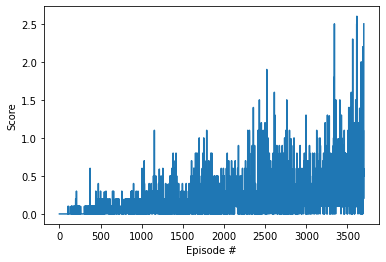

In [8]:
scores = ddpg(env, brain_name, finish_score=0.5)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Try out the agent
Run the next cell to download the agent from the checkpoints and see it in action through a number of episodes!

Episode 5	Average Score: 0.64


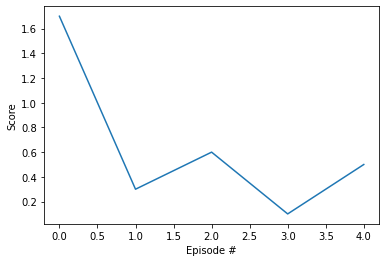

In [12]:
def run_model_from_checkpoint(checkpoint_actor="checkpoint_actor.pth", checkpoint_critic="checkpoint_critic.pth",
                          number_of_episodes=5):
    agent = Agent(state_size=2*state_size, action_size=2*action_size, random_seed=0)
    agent.actor_local.load_state_dict(torch.load(checkpoint_actor))
    agent.critic_local.load_state_dict(torch.load(checkpoint_critic))
    scores_deque = deque(maxlen=number_of_episodes)
    for i_episode in range(1, number_of_episodes+1):
        score = np.max(run_ddpg_for_one_episode(agent, env, brain_name, False)) 
        scores_deque.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % number_of_episodes == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores_deque)), scores_deque)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    
run_model_from_checkpoint()

When finished, you can close the environment.

In [6]:
env.close()